In [1]:
library("dplyr")
library("ggplot2")
library("cowplot")


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Warning message:
“package ‘cowplot’ was built under R version 3.6.3”

#### Observations

In [10]:
num_tails = 7
num_heads = 3
tosses = num_heads+num_tails

#### Generates a "Triangle" Prior Probability Distribution

In [11]:
#' Generates a "Triangle" Prior Probability Distribution
#'
#' @param vals Sample space of all possible parameter values.
#' @return 2 column dataframe containing the parameter and its corresponding
#'   prior probability.
get_prior_distr <- function(vals) {
  vals_pmin <- pmin(vals, 1 - vals)

  # Normalize the prior so that they sum to 1.
  tibble::tibble(
    theta = vals,
    prior = vals_pmin / sum(vals_pmin)
  )
}

# Define the Space of all theta values
theta_vals <- seq(0, 1, 0.1)

theta_prior_distr_df <- get_prior_distr(theta_vals)
theta_prior_distr_df

theta,prior
0.0,0.00
0.1,0.04
0.2,0.08
0.3,0.12
0.4,0.16
0.5,0.20
0.6,0.16
0.7,0.12
0.8,0.08
0.9,0.04


#### Plots the Prior Probability Distribution

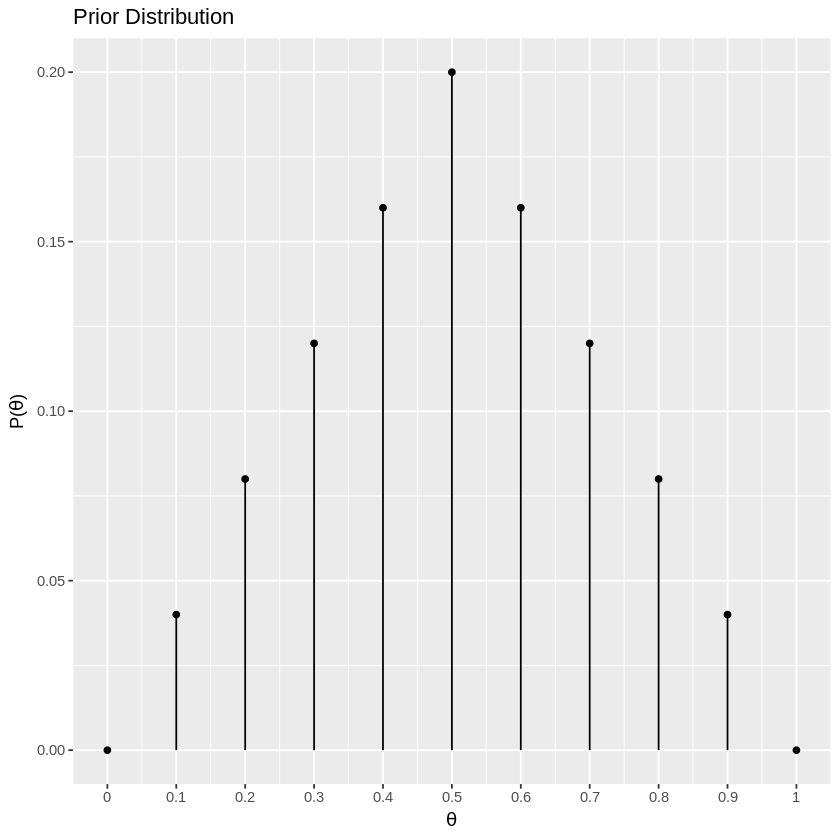

In [12]:
#' Plots the Prior Probability Distribution
#'
#' @param prior_distr_df Prior probability distribution dataframe from 
#'   get_prior_distr().
#' @param plot_x_labels Plot the parameter values on the x-axes that are taken
#'  from the input data.
#' @return ggplot of the prior probability distribution
plot_prior_distr <- function(prior_distr_df, plot_x_labels = TRUE) {

  theta_prior_p <- 
    prior_distr_df %>%
    ggplot(aes(x = theta, y = prior)) +
    geom_point() +
    geom_segment(aes(x = theta, xend = theta, y = prior, yend = 0)) +
    xlab(expression(theta)) +
    ylab(expression(paste("P(", theta, ")"))) +
    ggtitle("Prior Distribution") 

  if (plot_x_labels) {
    theta_vals <- prior_distr_df[["theta"]]

    theta_prior_p <- 
      theta_prior_p + 
      scale_x_continuous(breaks = c(theta_vals), labels = theta_vals)
  }

  return(theta_prior_p)
}

plot_prior_distr(theta_prior_distr_df)

#### Get the Likelihood Probability Distribution

In [27]:
#' Get the Likelihood Probability Distribution
#'
#' Generates a likelihood probability distribution dataframe
#'
#' @param theta_vals Vector of theta values for the binomial distribution.
#' @param num_heads Number of heads.
#' @param num_tails Number of tails.
#' @return Dataframe of the likelihood probability distribution.
get_likelihood_df <- function(theta_vals, num_heads, num_tails) {
  
  # qst assing using likelihood probability function  
  likelihood.vals <- c()
  for (cur.theta.val in theta_vals) {
    likelihood.vals <- 
      c(likelihood.vals, 
        (cur.theta.val^num_tails) * (1 - cur.theta.val)^(num_heads))
  }

    # then overwrites?? withbinom function priors
    binoms <- dbinom(num_tails, num_heads + num_tails, theta_vals)
    likelihood_df <- 
    tibble::tibble(
        theta = theta_vals,
        likelihood = likelihood.vals,
        binoms = binoms
    )

  return(likelihood_df)
}

likelihood_df = get_likelihood_df(theta_vals,num_heads,num_tails)
likelihood_df

theta,likelihood,binoms
0.0,0.0000000000,0.000000000
0.1,0.0000000729,0.000008748
0.2,0.0000065536,0.000786432
0.3,0.0000750141,0.009001692
0.4,0.0003538944,0.042467328
0.5,0.0009765625,0.117187500
0.6,0.0017915904,0.214990848
0.7,0.0022235661,0.266827932
0.8,0.0016777216,0.201326592
0.9,0.0004782969,0.057395628


#### Get Posterior Probability Distribution

In [14]:
#' Get Posterior Probability Distribution
#' 
#' Generate a posterior probability distribution dataframe.
#'
#' @param likelihood_df Likelihood distribution dataframe from 
#'   get_likelihood_df().
#' @param theta_prior_distr_df Prior distribution dataframe from 
#'   get_prior_distr().
#' @return Dataframe with 4 columns:
#'   * theta: Theta value.
#'   * likelihood: Binomial likelihood of the observed data with the specific 
#'       theta.
#'   * prior: Prior of the theta value.
#'   * post_prob: Pposterior probability
get_posterior_df <- function(likelihood_df, prior_distr_df) {

    # left join on theta
    likelihood_prior_df <- 
    dplyr::left_join(likelihood_df, prior_distr_df, by = "theta")
    
    # marginal = sum(likelihood*prior)
    marg_likelihood <- 
        likelihood_prior_df %>%
            dplyr::mutate(
              likelihood_theta = .data[["likelihood"]] * .data[["prior"]]
            ) %>%
            dplyr::pull("likelihood_theta") %>%
            sum()

    # posterior = (likelihood * prior) / marg_likelihood
    posterior_df <- 
    dplyr::mutate(
    likelihood_prior_df, 
    post_prob = (likelihood * prior) / marg_likelihood
    )

  return(posterior_df)
}

In [18]:
posterior_df = get_posterior_df(likelihood_df,theta_prior_distr_df)
posterior_df

theta,likelihood,binoms,prior,post_prob
0.0,0.0000000000,0.000000000,0.00,0.000000e+00
0.1,0.0000000729,0.000008748,0.04,3.011474e-06
0.2,0.0000065536,0.000786432,0.08,5.414540e-04
0.3,0.0000750141,0.009001692,0.12,9.296421e-03
0.4,0.0003538944,0.042467328,0.16,5.847703e-02
0.5,0.0009765625,0.117187500,0.20,2.017073e-01
0.6,0.0017915904,0.214990848,0.16,2.960400e-01
0.7,0.0022235661,0.266827932,0.12,2.755643e-01
0.8,0.0016777216,0.201326592,0.08,1.386122e-01
0.9,0.0004782969,0.057395628,0.04,1.975828e-02


In [28]:
#' Plots Likelihood Probability Distribution
plot_likelihood_prob_distr <- function(likelihood_df) {
  likelihood_df %>%
  ggplot(aes(x = theta, y = likelihood)) +
  geom_point() +
  geom_segment(aes(x = theta, xend = theta, y = likelihood, yend = 0)) +
  xlab(expression(theta)) +
  ylab(expression(paste("P(D|", theta, ")"))) +
  ggtitle("Likelihood Distribution")
}

#' Plots Posterior Probability Distribution
plot_posterior_prob_distr <- function(posterior_df, theta_vals) {
  posterior_df %>%
  ggplot(aes(x = theta, y = post_prob)) +
  geom_point() +
  geom_segment(aes(x = theta, xend = theta, y = post_prob, yend = 0)) +
  xlab(expression(theta)) +
  ylab(expression(paste("P(", theta, "|D)"))) +
  ggtitle("Posterior Distribution")
}

likelihood_df <- get_likelihood_df(theta_vals, num_heads,num_tails)
posterior_df <- get_posterior_df(likelihood_df, theta_prior_distr_df)

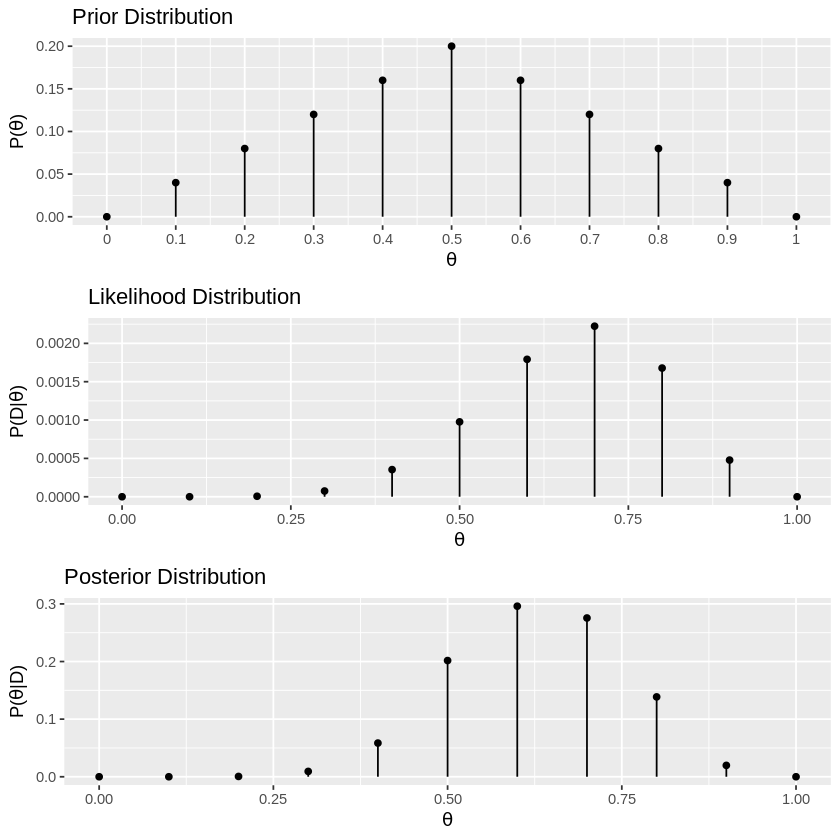

In [29]:
plot_grid(
  plot_prior_distr(theta_prior_distr_df),
  plot_likelihood_prob_distr(likelihood_df),
  plot_posterior_prob_distr(posterior_df, theta_vals),
  nrow = 3
)